1. cuda device
2. torchvision.datasets: FashionMNIST 데이터
- transform 인자: torchvision.transforms.Compose([])
	- ToTensor(): tensor 화
3. batch size 변수, dataloader
4. 이미지 시각화
- subplot, imshow, title, tight_layout, show
5. 모델 클래스 생성 (init, forward): FashionDNN


6. lr, model 객체, device 에 올리기, criterion, optimizer 정의
7. epochs 수 정하기
- epoch for 문
	- train 순서
		- model train 모드로
		- loss, total, correct = 0
			- loader for문
				- img, label device 에 올리기
				- img 배치 유동적으로 차원 변환 (model 에서 했으면 안 해도 됨)
				- model 에 넣기
				- loss
				- optimizer zero grad, 기울기 계산, 역전파 수행 (train 에서만)
				- 현재의 배치 구하고 loss 누적
				- pred 구하고 correct 구하기
				- total 구하기
			- avg loss, acc 계산
	- test 순서
		- model eval 모드로
		- loss, total, correct = 0
		- no grad()
			- loader for 문
				- 동일
			- avg loss, acc 계산
	- loss, acc 출력

-> FashionCNN 도 동일하게 (6, 7)



In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torchvision
from torchvision import transforms

train_dataset = torchvision.datasets.FashionMNIST("/FasionMNIST", download = True,
                                                 transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/FasionMNIST", download = True,
                                                 transform = transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 228kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.2MB/s]


In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

torch.Size([1, 28, 28])


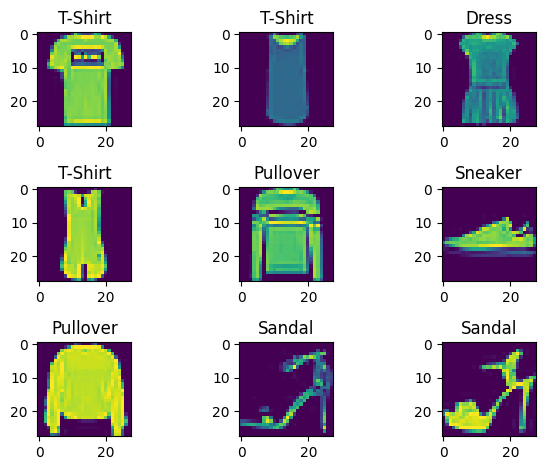

In [ ]:
img_tensor, label = train_dataset[0]
print(img_tensor.shape)

import matplotlib.pyplot as plt

label_dict = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
              4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

for i in range(1, 10):
  plt.subplot(3, 3, i)
  img, lb = train_dataset[i]
  plt.imshow(img.squeeze(0))
  plt.title(label_dict[lb])
plt.tight_layout()
plt.show()

In [ ]:
# FashionDNN

import torch.nn as nn

class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 10)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(0.1)

  def forward(self, x):
    x = x.view(x.size(0), -1) # (B, 1, 28, 28) => (B, 784) (fc에 넣기 위해)
    out = self.fc1(x)
    out = self.relu(out)

    out = self.drop(out)

    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out

In [ ]:
learning_rate = 0.001

from torch.optim import Adam

model = FashionDNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = learning_rate)

print(model)

In [ ]:
epochs = 100


for epoch in range(epochs):
  model.train()
  train_loss = 0
  train_total = 0
  train_correct = 0
  for img, label in train_loader:
    img, label = img.to(device), label.to(device)

    # img: [B, 1, 28, 28]
    # forward: x.view(-1, 784)
    #img = img.view(img.size(0), -1)

    out = model(img)
    loss = criterion(out, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # item(): tensor 에서 scalar 로
    # loss.item() 은 하나의 배치에 대한 "평균" loss 임
    bs = label.size(0)
    train_loss += loss.item() * bs

    # _, pred = torch.max(out, 1)
    pred = out.argmax(dim = 1)

    train_correct += (pred == label).sum().item()
    train_total += bs

  avg_train_loss = train_loss / train_total
  avg_train_acc = train_correct / train_total * 100

  model.eval()
  test_loss = 0
  test_total = 0
  test_correct = 0
  with torch.no_grad():
    for img_test, label_test in test_loader:
      img_test, label_test = img_test.to(device), label_test.to(device)

      #img_test = img_test.view(img_test.size(0), -1)

      out_test = model(img_test)

      loss = criterion(out_test, label_test)

      bs = label_test.size(0)
      test_loss += loss.item() * bs

      # _, pred = torch.max(out_test, 1)
      pred = out_test.argmax(dim = 1)

      test_correct += (pred == label_test).sum().item()
      test_total += bs

  avg_test_loss = test_loss / test_total
  avg_test_acc = test_correct / test_total * 100

  print(
        f"[{epoch+1}/{epochs}] "
        f"train_loss: {avg_train_loss:.4f}, train_acc: {avg_train_acc:.2f}% | "
        f"test_loss: {avg_test_loss:.4f}, test_acc: {avg_test_acc:.2f}%"
    )

In [ ]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()

    self.layer1 = nn.Sequential(
        # [1, 28, 28] -> [32, 28, 28] : (28-3+2*1)/1 + 1 = 28
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        # [32, 28, 28] -> [32, 14, 14] : 28 / 2 = 14
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        # [32, 14, 14] -> [64, 12, 12] : (14-3+2*0)/1 + 1 = 12
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 0),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # [64, 12, 12] -> [64, 6, 6] : 12/2 = 6
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.fc1 = nn.Linear(in_features = 64*6*6, out_features = 512)
    self.fc2 = nn.Linear(in_features = 512, out_features = 128)
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(0.1)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)

    out = out.view(out.size(0), -1)

    out = self.fc1(out)
    out = self.relu(out)
    out = self.drop(out)

    out = self.fc2(out)
    out = self.relu(out)
    out = self.drop(out)

    out = self.fc3(out)

    return out

In [ ]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = learning_rate)

In [ ]:
epochs = 100

for epoch in range(epochs):
  model.train()
  train_loss = 0
  train_total = 0
  train_correct = 0

  for img, label in train_loader:
    img, label = img.to(device), label.to(device)
    output = model(img)
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    bs = img.size(0)
    train_loss += loss.item() * bs

    pred = output.argmax(dim = 1) # softmax 를 모델에서 마지막에 안 해준 이유는 ce 에 포함
    train_correct += (pred == label).sum().item()

    train_total += bs

  avg_train_loss = train_loss / train_total
  train_acc = train_correct / train_total  * 100

  model.eval()
  test_loss = 0
  test_total = 0
  test_correct = 0

  with torch.no_grad():
    for img_test, label_test in test_loader:
      img_test, label_test = img_test.to(device), label_test.to(device)
      output = model(img_test)
      loss = criterion(output, label_test)

      bs = img_test.size(0)
      test_loss += loss.item() * bs

      pred = output.argmax(dim = 1)
      test_correct += (pred == label_test).sum().item()
      test_total += bs

  avg_test_loss = test_loss / test_total
  test_acc = test_correct / test_total * 100

  print(
        f"[{epoch+1}/{epochs}] "
        f"train_loss: {avg_train_loss:.4f}, train_acc: {train_acc:.2f}% | "
        f"test_loss: {avg_test_loss:.4f}, test_acc: {test_acc:.2f}%"
    )